In [9]:
import pickle
from pandas import read_csv

print("Loading data...")
training_file = './Data/train.p'

sign_names = read_csv("./Data/signname.csv").values[:, 1]
print(sign_names)

sign_forms = read_csv("./Data/signshape.csv").values
sign_dict = {}
for pair in sign_forms:
    sign_dict[pair[0]] = pair[1]
print(sign_dict)

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
images_train, labels_train = train['features'], train['labels']

forms_train = []
for i in range(len(labels_train)):
    forms_train.append(sign_dict.get(labels_train[i]))
    if labels_train[i] < 9:
        labels_train[i] = 0
    elif labels_train[i] >= 9:
        labels_train[i] = 1

Loading data...
['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vehicles over 3.5 metric']
{0: 0, 1: 0, 2: 0, 3: 0

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Assuming image dimensions
height = 32  # example height
width = 32   # example width
channels = 3  # RGB channels

# Input layer
inputs = Input(shape=(height, width, channels))

# Convolutional layers
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Shared dense layer
shared_dense = Dense(128, activation='relu')(x)
shared_dense = Dropout(0.5)(shared_dense)

# Head 1: Binary classification (street sign or no street sign)
head_1 = Dense(64, activation='relu')(shared_dense)
head_1 = Dropout(0.5)(head_1)
binary_output = Dense(1, activation='sigmoid', name='type_output')(head_1)

# Head 2: Multi-class classification (4 different shapes)
head_2 = Dense(64, activation='relu')(shared_dense)
head_2 = Dropout(0.5)(head_2)
shape_output = Dense(4, activation='softmax', name='shape_output')(head_2)

# Create the model
model = Model(inputs=inputs, outputs=[binary_output, shape_output])

# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {'type_output': 'binary_crossentropy', 
          'shape_output': 'sparse_categorical_crossentropy'}

lossWeights = {"type_output": 1.0, "shape_output": 1.0}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")

# Compile the model
model.compile(optimizer='adam', 
              loss=losses, 
              loss_weights=lossWeights,
              metrics=['accuracy']
              )

# Model summary
model.summary()

print("Finished building model...")

[INFO] compiling model...
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 32)           896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 16, 16, 64)           18496   

In [11]:
validation_file = './Data/valid.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
images_valid, labels_valid = valid['features'], valid['labels']

forms_valid = []
for i in range(len(labels_valid)):
    forms_valid.append(sign_dict.get(labels_valid[i]))
    if labels_valid[i] < 9:
        labels_valid[i] = 0
    elif labels_valid[i] >= 9:
        labels_valid[i] = 1

In [12]:
import numpy

forms_train = numpy.array(forms_train)
forms_valid = numpy.array(forms_valid)

print("Img train: ", len(images_train), images_train.dtype)
print("Form train: ", len(forms_train), type(forms_train))
print("Label train: ", len(labels_train), type(labels_train))

print("Img valid: ", len(images_valid), images_valid.dtype)
print("Form valid: ", len(forms_valid), type(forms_valid))
print("Label valid: ", len(labels_valid), type(labels_valid))

train_data = {'shape_output': forms_train, 'type_output': labels_train}
validation_data = {'shape_output': forms_valid, 'type_output': labels_valid}

# Train the model
history = model.fit(images_train, 
                    train_data, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(images_valid, validation_data))

Img train:  34799 uint8
Form train:  34799 <class 'numpy.ndarray'>
Label train:  34799 <class 'numpy.ndarray'>
Img valid:  4410 uint8
Form valid:  4410 <class 'numpy.ndarray'>
Label valid:  4410 <class 'numpy.ndarray'>
Epoch 1/10
1088/1088 [==============================] - 18s 16ms/step - loss: 0.7421 - type_output_loss: 0.3044 - shape_output_loss: 0.4378 - type_output_accuracy: 0.8734 - shape_output_accuracy: 0.8725 - val_loss: 0.1249 - val_type_output_loss: 0.0571 - val_shape_output_loss: 0.0677 - val_type_output_accuracy: 0.9821 - val_shape_output_accuracy: 0.9721
Epoch 2/10
1088/1088 [==============================] - 17s 16ms/step - loss: 0.1539 - type_output_loss: 0.0661 - shape_output_loss: 0.0878 - type_output_accuracy: 0.9801 - shape_output_accuracy: 0.9713 - val_loss: 0.0870 - val_type_output_loss: 0.0402 - val_shape_output_loss: 0.0468 - val_type_output_accuracy: 0.9916 - val_shape_output_accuracy: 0.9791
Epoch 3/10
1088/1088 [==============================] - 17s 16ms/step

In [13]:
# Define the file name for saving the model
model_filename = 'Multi-head-model'

# Save the model to a file
model.save(model_filename)

INFO:tensorflow:Assets written to: Multi-head-model/assets


INFO:tensorflow:Assets written to: Multi-head-model/assets


In [20]:
test_file = './Data/test.p'

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
images_test, labels_test = test['features'], test['labels']

forms_test = []
for i in range(len(labels_test)):
    forms_test.append(sign_dict.get(labels_test[i]))
    if labels_test[i] < 9:
        labels_test[i] = 0
    elif labels_test[i] >= 9:
        labels_test[i] = 1

In [23]:
forms_test = numpy.array(forms_test)

total_loss, loss_binary_output, loss_shape_output, accuracy_binary_output, accuracy_shape_output = model.evaluate(images_test, {'shape_output': forms_test, 'type_output': labels_test})

395/395 [==============================] - 2s 6ms/step - loss: 0.1604 - type_output_loss: 0.0223 - shape_output_loss: 0.1381 - type_output_accuracy: 0.9926 - shape_output_accuracy: 0.9904


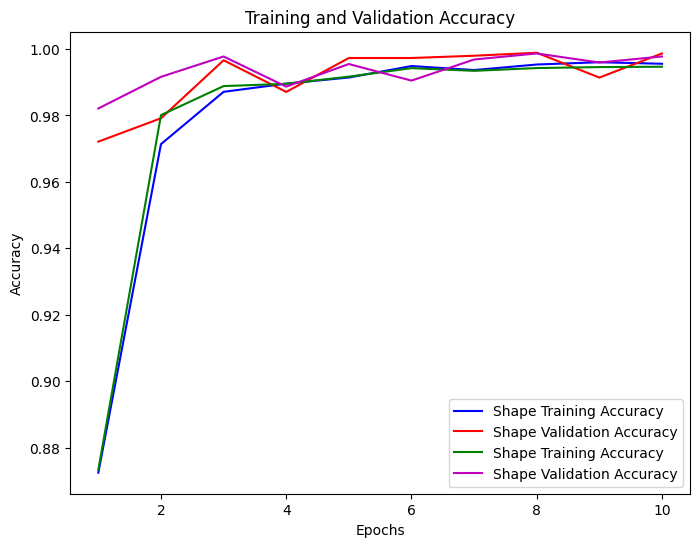

In [16]:
import matplotlib.pyplot as plt
 
# Extract accuracy values
shape_train_accuracy = history.history['shape_output_accuracy']
shape_val_accuracy = history.history['val_shape_output_accuracy']

type_train_accuracy = history.history['type_output_accuracy']
type_val_accuracy = history.history['val_type_output_accuracy']
 
# Plot accuracy
fig = plt.figure(figsize=(8, 6))
epochs = range(1, len(shape_train_accuracy) + 1)
plt.plot(epochs, shape_train_accuracy, 'b', label='Shape Training Accuracy')
plt.plot(epochs, shape_val_accuracy, 'r', label='Shape Validation Accuracy')
plt.plot(epochs, type_train_accuracy, 'g', label='Type Training Accuracy')
plt.plot(epochs, type_val_accuracy, 'm', label='Type Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('multihead_cnn.png', dpi=fig.dpi)